# Set up

In [0]:
!pip install --quiet gensim

# Data processing

In [2]:
from gensim.models import Word2Vec
from sklearn.model_selection import StratifiedKFold, train_test_split
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [0]:
def convert_word2vecs(x,model):
  x_ = np.array([model.wv[i] for i in x])
  return x_

def convert_word2vecs_new(x,model):
  x_ = np.array([model.wv[i.split(' ')] for i in x])
  return x_

def data_list_to_diction(sample_data):
  data = {}
  for i,_ in enumerate(sample_data):
    if sample_data[i][1] not in data.keys():
      data[sample_data[i][1]] = [sample_data[i][0]]
    else:
      data[sample_data[i][1]].append(sample_data[i][0])
  return data

def get_unique_patterns(d):
  u = {}
  for i in d.keys():
    m = {}
    l = list(set(d[i]))
    m['pattern_strs'] = l
    m['pattern_len'] = len(l)
    u[i] = m
  return u

def show_plt(d):
  o = [i for i in d.keys()]
  y_pos = np.arange(len(d))
  p = [d[k]['pattern_len'] for k in d.keys()]
  plt.barh(y_pos, p,alpha=0.5)
  plt.yticks(y_pos, o)
  plt.xlabel('# of unique patterns')
  plt.ylabel('Unique Patterns')
  plt.show()
  return max(p)

def eq(d):
  max_num = max([d[i]['pattern_len'] for i in d.keys()])
  for i in d:
    while d[i]['pattern_len'] != max_num:
      offset = d[i]['pattern_len'] - max_num
      if offset < 0:
        for _ in range(abs(offset)):
          d[i]['pattern_strs'].append(np.random.choice(d[i]['pattern_strs']))
        d[i]['pattern_len'] = len(d[i]['pattern_strs'])
      if offset > 0:
        d[i]['pattern_strs'] = d[i]['pattern_strs'][:max_num]
        d[i]['pattern_len'] = len(d[i]['pattern_strs'])
  return d

def data_augment(sample, count=100):
  if type(sample) is dict:
    main_data = []
    for k in sample.keys():
      l = sample[k]
      for i in l:
        for _ in range(count):
          main_data.append([k, i])
    return main_data
  if type(sample) is list:
    sample_diction = data_list_to_diction(sample)
    return data_augment(sample_diction,count)

In [0]:
raw_data = pickle.load(open('raw_data', 'rb'))

In [0]:
x_ner = raw_data['x_ner']
y_ner = raw_data['y_ner']
x_intent = raw_data['x_intent']
y_intent = raw_data['y_intent']

In [6]:
x_ner[:5], y_ner[:5]

([['d', 'i', 's', 't', 'a', 'n', 'c', 'e'],
  ['a', 'm', 'o', 'u', 'n', 't'],
  ['w', 'i', 't', 'h', 'o', 'u', 't'],
  ['s', 'h', 'o', 'u', 'l', 'd'],
  ['h', 'e', 'r', 'e']],
 ['O', 'O', 'O', 'O', 'O'])

In [7]:
x_intent[:5], y_intent[:5]

(['BOS i want a flight that leaves from charlotte to newark that leaves in the afternoon or evening EOS',
  'BOS list all flights from cleveland to kansas city on monday EOS',
  'BOS what is your cheapest flight from pittsburgh to denver EOS',
  'BOS what is the latest flight you have departing dallas to philadelphia EOS',
  'BOS how do you get from the airport to downtown dallas please EOS'],
 ['atis_flight', 'atis_flight', 'atis_flight', 'atis_flight', 'atis_flight'])

**Build embedded model**

In [0]:
sent_intent = [i.split(' ')  for i in x_intent]
sent_ner = [i for i in x_ner]

# print(sent_intent[0])
# print(sent_ner[0])
em_model = Word2Vec(min_count=1, workers=3)

em_model.build_vocab(sent_intent, update=False)
em_model.train(sent_intent,total_examples=em_model.corpus_count, epochs=10 )

em_model.build_vocab(sent_ner, update=True)
em_model.train(sent_ner,total_examples=em_model.corpus_count, epochs=10 )

em_model.save('em_model')

In [0]:
y_diction_ner = dict((v,i) for i,v in enumerate(list(set(y_ner))))
y_diction_intent = dict((v,i) for i,v in enumerate(list(set(y_intent))))

In [10]:
x__ner = pad_sequences(convert_word2vecs(x_ner, em_model), maxlen=16, dtype='float32', padding='pre', truncating='pre', value=0.0)
x__ner.shape

(104962, 16, 100)

In [11]:
x__intent = pad_sequences(convert_word2vecs_new(x_intent, em_model), maxlen=16, dtype='float32', padding='pre', truncating='pre', value=0.0)
x__intent.shape

(104962, 16, 100)

In [0]:
y_rev_diction_ner = dict((v,i) for i,v in zip(y_diction_ner.keys(), y_diction_ner.values()))
y_rev_diction_intent = dict((v,i) for i,v in zip(y_diction_intent.keys(), y_diction_intent.values()))

In [0]:
y__ner = np.array([[y_diction_ner[w]] for w in y_ner])
y__intent = np.array([[y_diction_intent[w]] for w in y_intent])

In [14]:
print(x__ner.shape, y__ner.shape, x__intent.shape, y__intent.shape)

(104962, 16, 100) (104962, 1) (104962, 16, 100) (104962, 1)


In [0]:
features_ner, features_ner_val_x , labels_ner, labels_ner_val_y  = train_test_split(x__ner,y__ner,test_size=0.2,random_state=0)

In [0]:
features_intent, features_intent_val_x , labels_intent , labels_intent_val_y  = train_test_split(x__intent,y__intent,test_size=0.2,random_state=0)

In [0]:
labels_ner = pad_sequences(labels_ner, maxlen=32, dtype='float32', padding='pre', truncating='pre', value=0.0)
labels_ner_val_y = pad_sequences(labels_ner_val_y, maxlen=32, dtype='float32', padding='pre', truncating='pre', value=0.0)

In [18]:
print('ner shapes ..')
print(features_ner.shape, features_ner_val_x.shape , labels_ner.shape, labels_ner_val_y.shape)
print('intent shapes ..')
print(features_intent.shape, features_intent_val_x.shape , labels_intent.shape, labels_intent_val_y.shape)

ner shapes ..
(83969, 16, 100) (20993, 16, 100) (83969, 32) (20993, 32)
intent shapes ..
(83969, 16, 100) (20993, 16, 100) (83969, 1) (20993, 1)


# Model

In [0]:
from keras.layers import Conv1D, MaxPooling1D
from keras.layers.merge import Concatenate

from keras.models import Model
from keras.layers.core import Dense, Dropout, Flatten
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint

from keras.layers import Bidirectional, TimeDistributed, RepeatVector, Input
from keras.layers.recurrent import LSTM
import keras

In [20]:
kernel = [3, 4, 5]
feature_maps = 100

def build_model():
  """Function to build model."""
  ctx_input = Input(shape=(16,100), name='ctx_input_layer')
  
  # ctx cnn block
  ctx_cnn_1 = Conv1D(filters=feature_maps, kernel_size=kernel[0], activation='relu', name='ctx_cnn_1')(ctx_input)
  maxpool_cnn_1 = MaxPooling1D(pool_size=1, strides=1, padding='valid', name='ctx_maxpool_1')(ctx_cnn_1)
  ctx_cnn_2 = Conv1D(filters=feature_maps, kernel_size=kernel[1], activation='relu', name='ctx_cnn_2')(ctx_input)
  maxpool_cnn_2 = MaxPooling1D(pool_size=1, strides=1, padding='valid', name='ctx_maxpool_2')(ctx_cnn_2)
  ctx_cnn_3 = Conv1D(filters=feature_maps, kernel_size=kernel[2], activation='relu', name='ctx_cnn_3')(ctx_input)
  maxpool_cnn_3 = MaxPooling1D(pool_size=1, strides=1, padding='valid', name='ctx_maxpool_3')(ctx_cnn_3)
  
  # ctx block
  ctx = keras.layers.concatenate([maxpool_cnn_1, maxpool_cnn_2, maxpool_cnn_3], axis=1)
  
  ctx_layer_1 = LSTM(32, name='ctx_layer_1')(ctx)
  ctx_layer_2 = Dropout(0.3, name='ctx_drop_layer_1')(ctx_layer_1)
  ctx_layer_3 = RepeatVector(32, name='ctx_layer_2')(ctx_layer_2)
  ctx_layer_4 = Bidirectional(LSTM(32, return_sequences=True), name='ctx_layer_3')(ctx_layer_3)
  ctx_layer_5 = Flatten(name='ctx_flatten_1')(ctx_layer_4)
  ctx_output = Dense(26, name='ctx_prediction', activation='softmax')(ctx_layer_5)
  
  ner_input = Input(shape=(16,100), name='ner_input_layer')
  
  # ner cnn block
  ner_cnn_1 = Conv1D(filters=feature_maps, kernel_size=kernel[0], activation='relu', name='ner_cnn_1')(ner_input)
  maxpool_ner_1 = MaxPooling1D(pool_size=2, strides=1, padding='valid', name='maxpool_ner_1')(ner_cnn_1)
  ner_cnn_2 = Conv1D(filters=feature_maps, kernel_size=kernel[1], activation='relu', name='ner_cnn_2')(ner_input)
  maxpool_ner_2 = MaxPooling1D(pool_size=2, strides=1, padding='valid', name='maxpool_ner_2')(ner_cnn_2)
  ner_cnn_3 = Conv1D(filters=feature_maps, kernel_size=kernel[2], activation='relu', name='ner_cnn_3')(ner_input)
  maxpool_ner_3 = MaxPooling1D(pool_size=2, strides=1, padding='valid', name='maxpool_ner_3')(ner_cnn_3)
  
  ner = keras.layers.concatenate([maxpool_ner_1, maxpool_ner_2, maxpool_ner_3], axis=1)
  
  # ner block
  ner_layer_1 = LSTM(128, name='ner_layer_1')(ner)
  ner_layer_2 = Dropout(0.3, name='ner_drop_layer_1')(ner_layer_1)
  ner_layer_3 = RepeatVector(32, name='ner_layer_4')(ner_layer_2)
  ner_layer_4 = Bidirectional(LSTM(32, return_sequences=True), name='ner_layer_5')(ner_layer_3)
  ner_layer_5 = keras.layers.concatenate([ctx_layer_4, ner_layer_4])
  ner_output = TimeDistributed(Dense(127, name='predictions_layer' ,activation='softmax'), name='ner_time_layers')(ner_layer_5)
  
  # model 
  model = Model(inputs=[ctx_input, ner_input], outputs=[ctx_output, ner_output])
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

model = build_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ctx_input_layer (InputLayer)    (None, 16, 100)      0                                            
__________________________________________________________________________________________________
ner_input_layer (InputLayer)    (None, 16, 100)      0                                            
__________________________________________________________________________________________________
ctx_cnn_1 (Conv1D)              (None, 14, 100)      30100       ctx_input_layer[0][0]            
__________________________________________________________________________________________________
ctx_cnn_2 (Conv1D)   

In [0]:
from keras.utils import plot_model

In [0]:
plot_model(model, to_file="joint_model_cnn.png")

# Training

In [0]:
!mkdir chkpts
save_path = 'chkpts/'

In [0]:
def plot_history(history,num):
    ctx_loss_list = [s for s in history.history.keys() if 'ctx_prediction_loss' in s and 'val' not in s]
    ner_loss_list = [s for s in history.history.keys() if 'ner_time_layers_loss' in s and 'val' not in s]
    
    val_ctx_loss_list = [s for s in history.history.keys() if 'ctx_prediction_loss' in s and 'val' in s]
    val_ner_loss_list = [s for s in history.history.keys() if 'ner_time_layers_loss' in s and 'val' in s]
    
    ctx_acc_list = [s for s in history.history.keys() if 'ctx_prediction_acc' in s and 'val' not in s]
    ner_acc_list = [s for s in history.history.keys() if 'ner_time_layers_acc' in s and 'val' not in s]
    
    val_ctx_acc_list = [s for s in history.history.keys() if 'ctx_prediction_acc' in s and 'val' in s]
    val_ner_acc_list = [s for s in history.history.keys() if 'ner_time_layers_acc' in s and 'val' in s]
    
    if len(ctx_loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[ctx_loss_list[0]]) + 1)
    
    ## Loss - ctx
    plt.figure(num, figsize=(8,5))
    for l in ctx_loss_list:
      plt.plot(epochs, history.history[l], 'b', label='Ctx Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    for l in val_ctx_loss_list:
      plt.plot(epochs, history.history[l], 'g', label='Ctx Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
#     plt.title('Context Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Context Loss')
#     plt.legend()
#     plt.savefig(save_path + 'ctx_loss_{0}.png'.format(num))
    
    ## Loss - ner
    plt.figure(num, figsize=(8,5))
    for l in ner_loss_list:
      plt.plot(epochs, history.history[l], 'r', label='NER Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_ner_loss_list:
      plt.plot(epochs, history.history[l], 'm', label='NER Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
#     plt.title('NER Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('NER Loss')
#     plt.legend()
#     plt.savefig(save_path + 'ner_loss_{0}.png'.format(num))
    
    ## Accuracy - ctx 
    plt.figure(num, figsize=(8,5))
    for l in ctx_acc_list:
        plt.plot(epochs, history.history[l], 'c', label='Ctx Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_ctx_acc_list:    
        plt.plot(epochs, history.history[l], 'y', label='Ctx Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

#     plt.title('Context Accuracy')
#     plt.xlabel('Epochs')
#     plt.ylabel('Context Accuracy')
#     plt.legend()
#     plt.savefig(save_path + 'ctx_acc_{0}.png'.format(num))
    
    ## Accuracy - ner
    plt.figure(num, figsize=(8,5))
    for l in ner_acc_list:
        plt.plot(epochs, history.history[l], 'b', linestyle='--', label='NER Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_ner_acc_list:    
        plt.plot(epochs, history.history[l], 'r', linestyle='--', label='NER Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Plot Image')
    plt.xlabel('Epochs')
    plt.ylabel('Context Loss / NER Loss/ Context Acc / NER Acc')
    plt.legend()
    plt.savefig(save_path + 'plot_image_{0}.svg'.format(num), format='svg')
#     plt.savefig(save_path + 'ner_acc_{0}.png'.format(num))
    

In [0]:
import gc

--> Cross Validation Score [0.998392799742848, 0.9758216811229538]
--> Cross Validation Score [0.9993925968272117, 0.9920356491897657]
--> Cross Validation Score [0.9993209920663284, 0.9940653813293413]


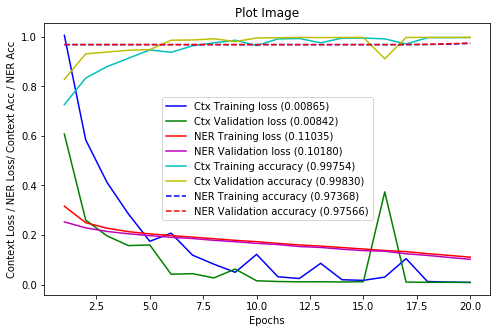

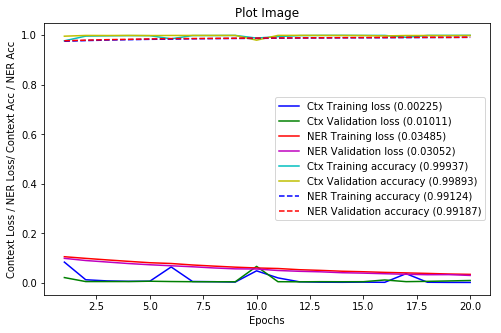

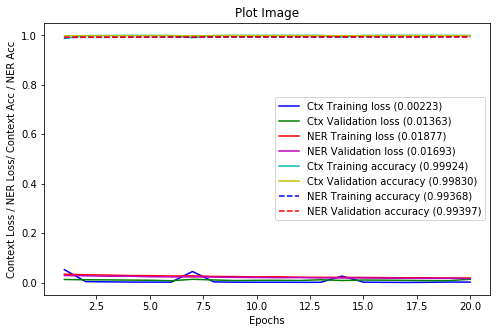

In [28]:
kfold = StratifiedKFold(n_splits=3, shuffle=True,random_state=16)
cvscores = []
history = []

intent = kfold.split(features_intent, labels_intent)
ner = kfold.split(features_intent, labels_intent)
i = 0

for intent_ , ner_  in zip(intent, ner):
    i += 1
    h = model.fit([features_intent[intent_[0]], features_ner[ner_[0]]], 
                [to_categorical(labels_intent[intent_[0]]), to_categorical(labels_ner[ner_[0]])],
                batch_size = 5000,
                validation_split=0.2,
                epochs=20,
                verbose=0,
                shuffle=True,
                callbacks=[ModelCheckpoint(save_path + 'model_mix_.h5', 
                                           monitor='val_ner_time_layers_acc',
                                           verbose=0,
                                           save_best_only=True,
                                           mode='auto')]
               )
    history.append(h)
    plot_history(h,i)
    scores = model.evaluate({'ctx_input_layer': features_intent[intent_[1]] , 'ner_input_layer' : features_ner[ner_[1]] } ,
                           {'ctx_prediction': to_categorical(labels_intent[intent_[1]]), 'ner_time_layers': to_categorical(labels_ner[ner_[1]]) },
                           verbose=0)
    print('--> Cross Validation Score', scores[-2:])
    cvscores.append(scores)
    gc.collect()